In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.base import elastic_net
from sklearn.linear_model import ElasticNet

sns.set(rc={"figure.figsize": (10, 5)})
plt.style.use("fivethirtyeight")

In [268]:
data = pd.read_csv("data/diff_in_diff.csv")
data.head()

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4


Here's what we know.
- At some point in time, the e-commerce company started giving discount coupons to women on Mother’s Day.

- At some point in time, the company started testing more aggressive discounting in the state MG.

In DiD, we need a situation where, *at some point in time*, the treatment changes for one group but not the other. In this sense, it is similar to RDD, only now the discontinuity has to be over time.

In [269]:
data.isnull().sum().reset_index()

,index,0
0,sales,0
1,discount,0
2,age,0
3,gender,4965
4,cust_state,0
5,tenure,0
6,profit,0
7,month,0


In [270]:
data.dtypes

sales         float64
discount        int64
age             int64
gender         object
cust_state     object
tenure          int64
profit        float64
month           int64
dtype: object

In [271]:
# data_cleaned_gender = data[data["gender"]!= "O"]
data_by_gender = (data
                    .groupby(by=["gender", "month"])
                    ["discount"]
                    .mean()
                    .reset_index())
data_by_gender

,gender,month,discount
0,M,0,0.000000
1,M,1,0.000000
2,M,2,0.000000
3,M,3,0.000000
4,M,4,0.000000
5,M,5,0.000000
6,M,6,0.000000
7,M,7,0.000000
8,M,8,0.000000
9,M,9,0.000000


<Axes: xlabel='month', ylabel='discount'>

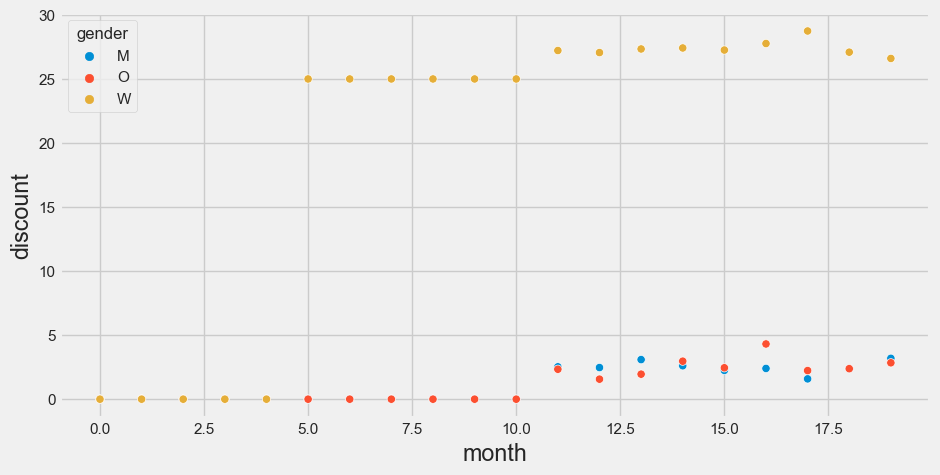

In [272]:
sns.scatterplot(
    data=data_by_gender,
    x="month",
    y="discount",
    hue="gender",
)

There is a sharp increase in discount for women at month 5. This aligns with what we know about the Mother's day discount.

In [273]:
data_by_state = (data
                    .groupby(["cust_state", "month"])
                    [["discount", "profit"]]
                    .mean()
                    .reset_index())
data_by_state

,cust_state,month,discount,profit
0,AC,0,0.000000,42.190000
1,AC,1,0.000000,42.866000
2,AC,2,0.000000,43.717143
3,AC,3,0.000000,42.665455
4,AC,4,0.000000,38.514000
...,...,...,...,...
531,TO,15,18.750000,36.892500
532,TO,16,25.000000,40.995000
533,TO,17,12.500000,51.265000
534,TO,18,8.333333,48.150000


In [274]:
data_by_state.query("cust_state == 'MG'")

,cust_state,month,discount,profit
198,MG,0,0.000000,82.880526
199,MG,1,0.000000,81.962991
200,MG,2,0.000000,86.363167
201,MG,3,0.000000,91.137815
202,MG,4,0.000000,94.415371
203,MG,5,11.510264,94.492962
204,MG,6,10.829493,97.832780
205,MG,7,10.947987,99.716309
206,MG,8,11.398678,102.156211
207,MG,9,10.455975,106.442233


/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='month', ylabel='discount'>

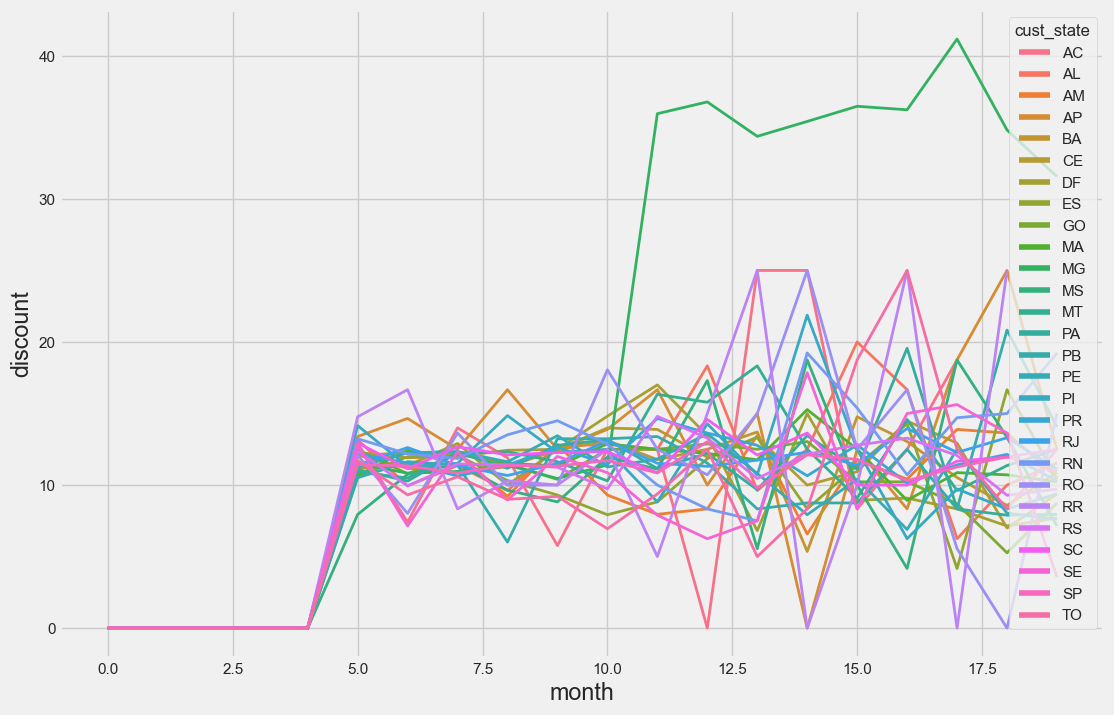

In [275]:
plt.figure(figsize=(12,8))
sns.lineplot(
    data=data_by_state,
    # data=data_by_state.query("cust_state == 'MG'"),
    x="month",
    y="discount",
    hue="cust_state",
    lw=2,
)

There is a spike in dicounts for state MG at month 10.

In [276]:
data = data.copy()
data = data.assign(
    post_intervention = data["month"] >= 5,  #? include month 5? ANS: Yes.
    treated = data["gender"] == "W",
)
data

,sales,discount,age,gender,cust_state,tenure,profit,month,post_intervention,treated
0,1153.28,0,25,O,MA,19,57.66,7,True,False
1,1978.13,0,26,M,MG,16,98.91,6,True,False
2,1095.70,0,26,W,RJ,20,54.78,2,False,True
3,2404.90,25,30,W,BA,18,95.24,6,True,True
4,1704.80,0,38,M,PB,15,85.24,4,False,False
...,...,...,...,...,...,...,...,...,...,...
49995,2083.30,0,29,W,SP,15,104.17,0,False,True
49996,1110.16,25,29,W,MT,16,30.51,13,True,True
49997,2495.62,25,31,M,MG,18,99.78,11,True,False
49998,1951.28,0,30,O,SP,24,97.56,0,False,False


In [277]:
#  average profit for treated group before the intervention
avg_profit_before = (data
                    .query("treated == True & post_intervention == False")
                    ["profit"]
                    .mean())

# average profit for treated group after the intervention

avg_profit_after =(data
                   .query("treated == True & post_intervention == True")
                   ["profit"]
                   .mean())
print(avg_profit_before, avg_profit_after)
print(f"Difference in profits before and after discount increase: {avg_profit_after - avg_profit_before:.2f}")

78.17665787623065 85.31840415612095
Difference in profits before and after discount increase: 7.14


Thie difference in profits before and after the discount is 9.64 This is the causal effect on discounts if the bias is 0. That is, women's profits is not changing with time.

In [278]:
avg_profit_men_after = (data
                            .query("treated == False & post_intervention == True")
                            ["profit"]
                            .mean())
print(avg_profit_men_after)

# difference in profits after the intervention between treated and control
print(avg_profit_after - avg_profit_men_after)

92.44278128831462
-7.124377132193672


This is the causal effect of discounts on profits if there is no bias in gender, that is, no effect of gender on profits.

These are strong assumptions. We will relax these assumptions using difference-in-differences, which only assumes that men and women have the similar growth trajectory.

/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


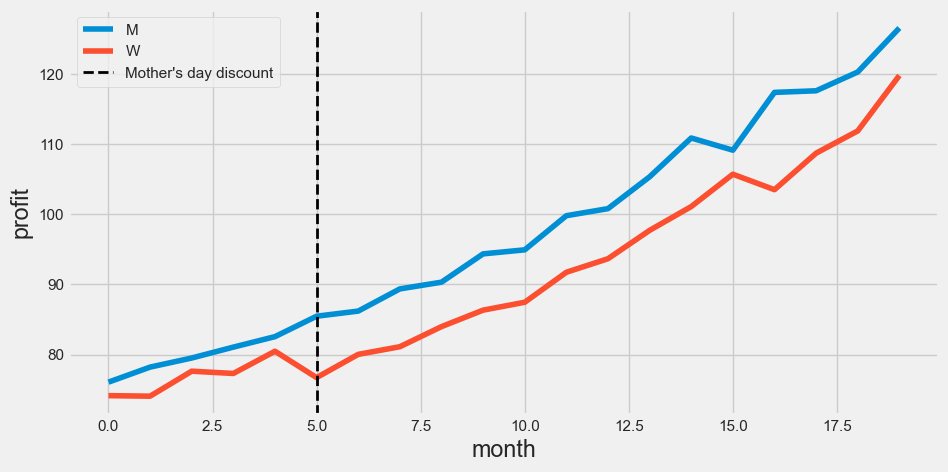

In [310]:
plt_df = (data
            .query("gender == 'W' or gender == 'M'") 
            .groupby(["gender", "month"])
            ["profit"]
            .mean()
            .reset_index())

sns.lineplot(
    data=plt_df,
    x="month",
    y="profit",
    hue="gender"
)
plt.axvline(x=5, linestyle="--", lw=2, color="black", label="Mother's day discount")
plt.legend()
plt.savefig("images/did.jpg")

- The treated and untreated have different profit levels before the intervention.
- The average profit of the treated is generally growing before the intervention.
- The treated and untreated have parallel profit trends before the intervention period.

# DiD Analysis

In [280]:
grouped_df = plt_df.copy()

# average profit for control group before the intervention
avg_profit_control_pre = (data
                            .query("treated == False and post_intervention == False")
                            ["profit"]
                            .mean())
print(f"Average profit for the control group before the intervention: {avg_profit_control_pre}")

avg_profit_control_post = (data
                            .query("treated == False and post_intervention == True")
                            ["profit"]
                            .mean())
print(f"Average profit for the control group after the intervention: {avg_profit_control_post}")

growth_in_control = avg_profit_control_post - avg_profit_control_pre;
print(f"Growth in control {growth_in_control}")


avg_profit_treated_pre = (data
                            .query("treated == True and post_intervention == False")
                            ["profit"]
                            .mean())
counterfactual_estimator = avg_profit_treated_pre + growth_in_control

avg_profit_treated_post = (data
                            .query("treated == True and post_intervention == True")
                            ["profit"]
                            .mean())

diff_in_diff_estimator = avg_profit_treated_post - counterfactual_estimator

print(f"Diff in diff estimator is {diff_in_diff_estimator}")

Average profit for the control group before the intervention: 80.5275333662877
Average profit for the control group after the intervention: 92.44278128831462
Growth in control 11.915247922026921
Diff in diff estimator is -4.7735016421366225


# DiD estimator using regression

$$
profit_i = \beta_0 + \beta_1 treated + \beta_2 post\_intervention + \beta_3 post\_intervention * treated
$$

$\beta_0$ is the baseline of the control i.e. the profit of control group pre intervention. If we turn on the treated dummy variable, we get $\beta_0 + \beta_1$, which is the baseline of the treatment group before the intervention. $\beta_1$ is the difference in baseline between treated and control groups. If we turn the treatment dummy off and turn the post-treatment dummy on, we get $\beta_0 + \beta_2$, which is the level of the control group after the intervention. $\beta_2$ is the trend/growth of the control. Putting it all together $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level of the treated group after the intervention. Thus, $\beta_3$ is the increment in the outcome we get by going from treated to control and from pre-to-post intervention period. In other words, the difference-in-difference estimator.


In [281]:
data

,sales,discount,age,gender,cust_state,tenure,profit,month,post_intervention,treated
0,1153.28,0,25,O,MA,19,57.66,7,True,False
1,1978.13,0,26,M,MG,16,98.91,6,True,False
2,1095.70,0,26,W,RJ,20,54.78,2,False,True
3,2404.90,25,30,W,BA,18,95.24,6,True,True
4,1704.80,0,38,M,PB,15,85.24,4,False,False
...,...,...,...,...,...,...,...,...,...,...
49995,2083.30,0,29,W,SP,15,104.17,0,False,True
49996,1110.16,25,29,W,MT,16,30.51,13,True,True
49997,2495.62,25,31,M,MG,18,99.78,11,True,False
49998,1951.28,0,30,O,SP,24,97.56,0,False,False


In [282]:
model = smf.ols(
    "profit ~ treated + post_intervention + post_intervention * treated", 
    data=data).fit()
print(model.summary().tables[1])

                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    80.5275      0.342    235.715      0.000      79.858      81.197
treated[T.True]                              -2.3509      0.532     -4.421      0.000      -3.393      -1.309
post_intervention[T.True]                    11.9152      0.402     29.673      0.000      11.128      12.702
post_intervention[T.True]:treated[T.True]    -4.7735      0.625     -7.642      0.000      -5.998      -3.549


The interaction coefficient is very close to the diff-in-diff estimator we calculated. This estimator can be interpreted as the causal effect if men's and women's profit have similar growth trajectories (parallel trends), which is a much weaker assumption to make. 

Thus, we see the treatement effect of giving \$25 in discount is -4.77, that is, for every \$1.00 in discount, the company can expect to lose about \$0.20.

# Synthetic Controls

Remember that we had a second source of variotion - how discounts increased for the state of MG after month 10 while remaining unchanged for the other states. We can leverage this source of variation through synthetic control.

The main idea is that instead of using a single state as control, we combine multiple control states into a synthetic control that behaves just like the state of MG in the preintervention period.

/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='month', ylabel='discount'>

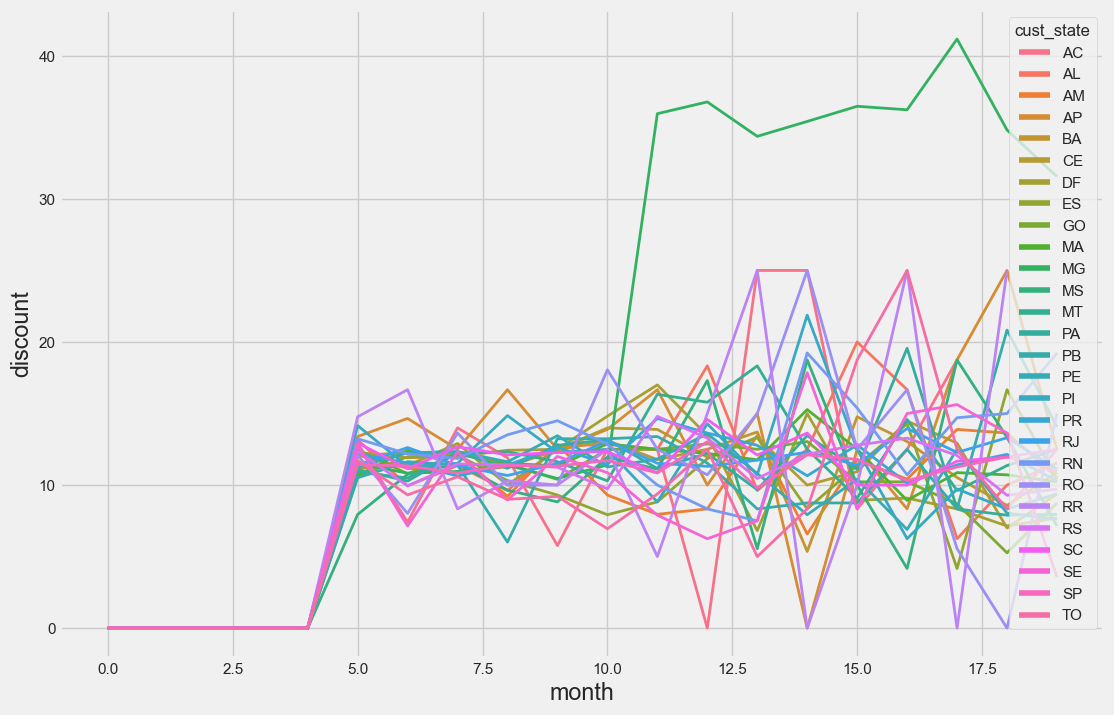

In [283]:
plt.figure(figsize=(12,8))
sns.lineplot(
    data=data_by_state,
    # data=data_by_state.query("cust_state == 'MG'"),
    x="month",
    y="discount",
    hue="cust_state",
    lw=2,
)

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_58372/3027617975.py:2: UserWarning: 
The palette list has fewer values (1) than needed (26) and will cycle, which may produce an uninterpretable plot.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/gregorytomy/miniconda3/envs/causal/lib/python3.11/site-packages

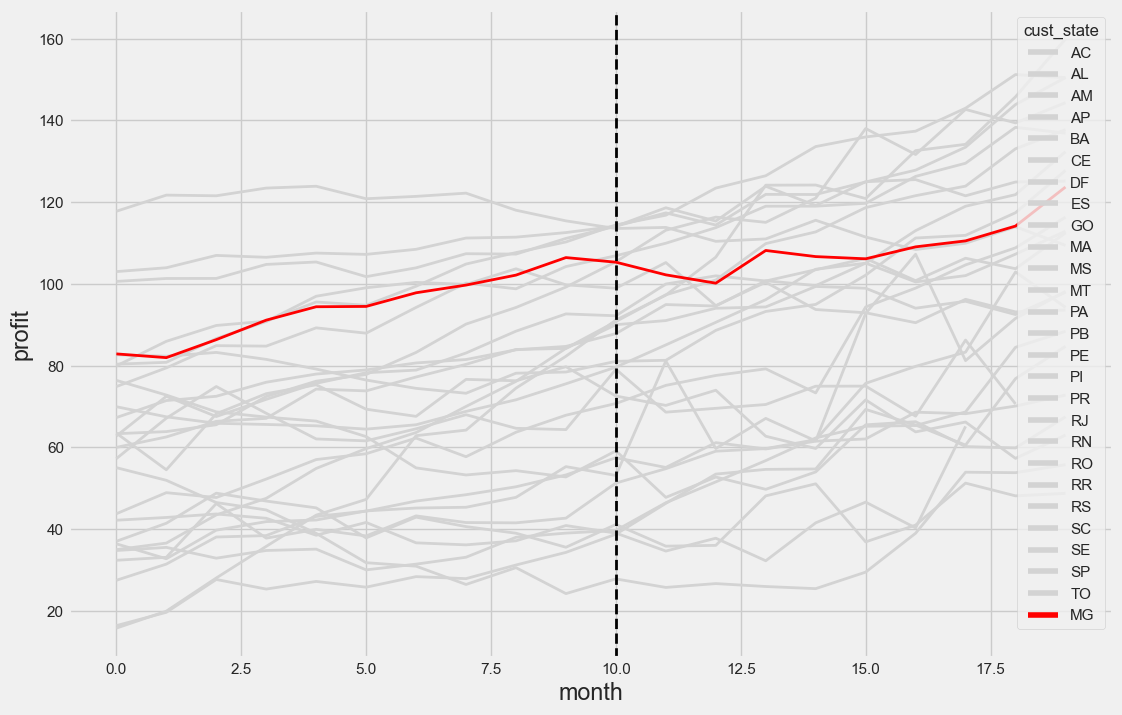

In [284]:
plt.figure(figsize=(12,8))
sns.lineplot(
    data=data_by_state.query("cust_state != 'MG'"),
    x="month",
    y="profit",
    hue="cust_state",
    palette=['lightgrey'],
    lw=2,
)

sns.lineplot(
    data=data_by_state.query("cust_state == 'MG'"),
    x="month",
    y="profit",
    hue="cust_state",
    lw=2,
    palette=["red"]
)
plt.axvline(x=10, linestyle="--", lw=2, color="black")

# Creating the Synthetic Control

In [285]:
pivoted_df = data_by_state.pivot(index="month", columns="cust_state", values="profit").fillna(0)
pivoted_df

cust_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
month,,,,,,,,,,,,,,,,,,,,,
0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,82.661935,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,82.319318,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060938,86.637955,121.561389,83.237867,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,81.540486,...,84.782019,65.616638,72.470250,52.260937,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,79.171152,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353
5,41.649310,31.797368,78.271926,69.351786,78.952319,94.778441,47.277660,99.057559,120.839486,76.483467,...,87.948212,64.472000,77.841933,58.454667,61.603636,59.706278,44.414685,25.810875,107.225881,37.867500
6,36.657037,30.944731,78.913917,67.600000,80.666347,99.432095,62.873523,100.371389,121.417048,74.451179,...,94.249459,65.543528,83.237983,62.283774,64.559333,63.646376,46.875233,28.390714,108.470502,42.945490
7,36.162400,26.473636,83.099060,76.647000,81.501328,104.863297,64.232796,99.888250,122.207006,73.252598,...,100.197857,68.812020,90.171667,57.726970,68.001905,70.021509,48.431675,27.899589,111.223821,40.630385
8,37.150000,30.585846,88.439079,76.303810,83.881258,107.663279,74.505429,103.699500,118.027143,78.157818,...,98.802412,71.648874,94.235135,63.720400,64.678824,76.161011,50.369689,31.233208,111.441579,39.010800


In [286]:
pre_intervention_df = pivoted_df.iloc[0:11]
pre_intervention_df

cust_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
month,,,,,,,,,,,,,,,,,,,,,
0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,82.661935,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,82.319318,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060938,86.637955,121.561389,83.237867,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,81.540486,...,84.782019,65.616638,72.470250,52.260937,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,79.171152,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353
5,41.649310,31.797368,78.271926,69.351786,78.952319,94.778441,47.277660,99.057559,120.839486,76.483467,...,87.948212,64.472000,77.841933,58.454667,61.603636,59.706278,44.414685,25.810875,107.225881,37.867500
6,36.657037,30.944731,78.913917,67.600000,80.666347,99.432095,62.873523,100.371389,121.417048,74.451179,...,94.249459,65.543528,83.237983,62.283774,64.559333,63.646376,46.875233,28.390714,108.470502,42.945490
7,36.162400,26.473636,83.099060,76.647000,81.501328,104.863297,64.232796,99.888250,122.207006,73.252598,...,100.197857,68.812020,90.171667,57.726970,68.001905,70.021509,48.431675,27.899589,111.223821,40.630385
8,37.150000,30.585846,88.439079,76.303810,83.881258,107.663279,74.505429,103.699500,118.027143,78.157818,...,98.802412,71.648874,94.235135,63.720400,64.678824,76.161011,50.369689,31.233208,111.441579,39.010800


## Getting weights

In [287]:
y = pre_intervention_df["MG"].values
X = pre_intervention_df.drop(columns="MG").values

model = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000)
model.fit(X, y)

weights = model.coef_
weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15666702, 0.06709938, 0.15451208, 0.14239844, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11871068,
       0.        , 0.08386732, 0.        , 0.11140646, 0.        ,
       0.        , 0.00979641, 0.        , 0.        , 0.13232692,
       0.        ])

In [288]:
synthetic_control_df = pivoted_df.drop(columns="MG").fillna(0).values
synthetic_control = synthetic_control_df.dot(weights)
synthetic_control

array([ 82.03056215,  84.54879919,  87.689239  ,  90.43252607,
        93.76770244,  93.43824919,  97.0876573 , 100.1759432 ,
       101.71088524, 103.36191277, 105.74886091, 109.68786782,
       109.17020599, 114.17917446, 115.04636528, 117.5955818 ,
       118.11083301, 121.99262304, 126.39896116, 128.03030073])

In [289]:
plt_df_2 = pd.DataFrame({
    "synthetic_control" : synthetic_control,
    "MG" : pivoted_df["MG"],
}, index=pivoted_df.index)

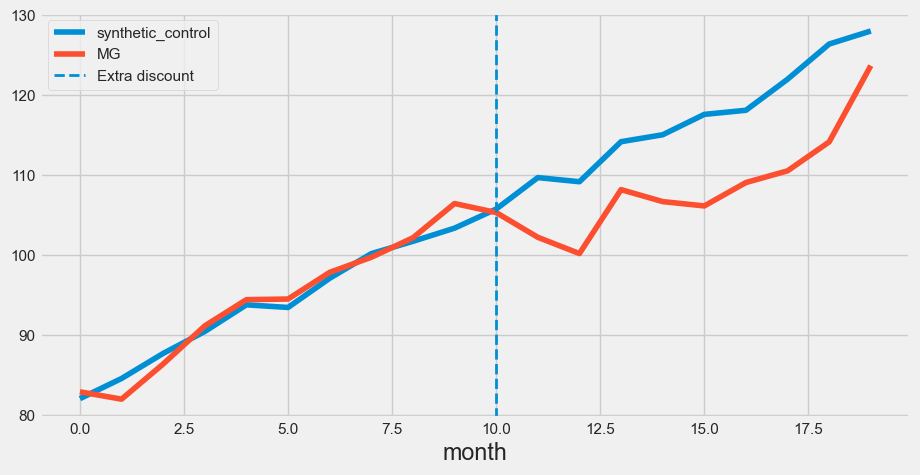

In [309]:
plt_df_2.plot(kind="line")
plt.axvline(x=10, linestyle="--", lw=2, label="Extra discount")
plt.legend()
plt.savefig("images/synthetic_control.jpg")

We see the profits for MG decreasing after the intervention which suggests that the effect of discounts on profit is negative.

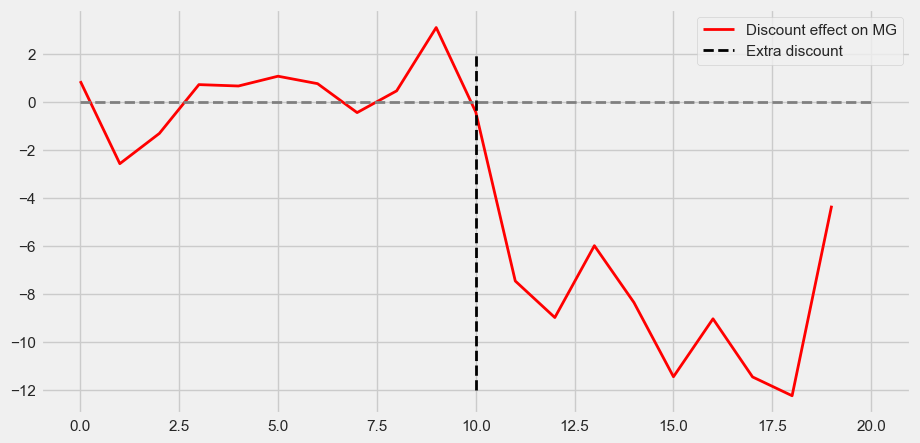

In [304]:
plt.plot(
    plt_df_2.index,
    plt_df_2["MG"] - plt_df_2["synthetic_control"],
    label="Discount effect on MG",
    lw=2,
    color="red",
)
plt.hlines(y=0, xmin=0, xmax=20, linestyles="--", lw=2, color="grey")
plt.vlines(x=10, ymin=-12, ymax= 2, linestyles="--", lw=2, color="black", label="Extra discount")
plt.legend()